## Import needed libraries

In [12]:
import numpy as np
import pathlib, os, random
from tqdm import tqdm
from tqdm.notebook import tqdm
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import albumentations as A

from PraNet.lib.PraNet_ResNeSt import Net

In [13]:
import torch
import torch.utils.data as D
import torchvision.transforms as T

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Check GPU
print(DEVICE)

cuda


In [14]:
class Dataset(D.Dataset):

    def __init__(self, root_dir, transform, name, train='images', mask='masks'):
        self.name = name
        self.path = pathlib.Path(root_dir)
        self.train_dir = train
        self.mask_dir = mask
        self.images = []
        self.masks = []
        self.transform = transform
        self.as_Tensor = T.Compose([
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
        ])
        self.load_image()

    def load_image(self):
        for i, filename in enumerate(tqdm(os.listdir(os.path.join(self.path, self.train_dir)))):
            img = cv2.imread((self.path / self.train_dir / filename).as_posix())
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (512, 512), cv2.INTER_CUBIC)
            msk = cv2.imread((self.path / self.mask_dir / filename).as_posix())
            msk = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
            msk = cv2.resize(msk, (512, 512), cv2.INTER_LINEAR)
            msk = cv2.morphologyEx(msk, cv2.MORPH_CLOSE, kernel=np.ones((5, 5),np.uint8))
            msk = cv2.medianBlur(msk, ksize=5)
            msk = np.clip(msk / 255, 0, 1).astype(np.uint8)

            self.images.append(img)
            self.masks.append(msk)

    def __getitem__(self, index):
        img, msk = self.images[index], self.masks[index]
        augments = self.transform(image=img, mask=msk)
        return self.as_Tensor(augments['image']), augments['mask'][None]

    def __len__(self):
        return len(self.images)

In [15]:
# Define
transform = A.Compose([
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
])

In [16]:
kvasir_test_dataset = Dataset('dataset/polyp-dataset/kvasir/test', transform=transform, name='KVASIR TEST')
cvc_test_dataset = Dataset('dataset/polyp-dataset/cvc/test', transform=transform, name='CVC TEST')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

In [17]:
model = Net().cuda()
model.load_state_dict(torch.load('Kvasir-output/model-best.pth'))
model = model.eval()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


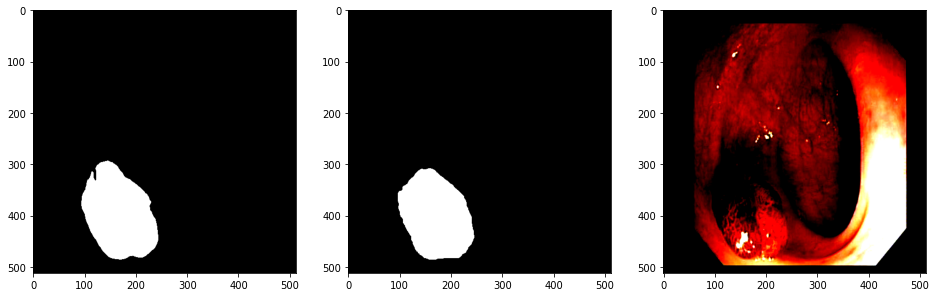

In [18]:
# Randomly inference on one CVC image
random_index = random.randint(0, len(cvc_test_dataset)+1)
img, gt = cvc_test_dataset[random_index]
img = img[None]
gt = gt
with torch.no_grad():
    _, _, _, pred = model(img.cuda())
    result = pred[0].sigmoid().cpu().numpy()[0]
    result[result >= 0.4] = 1
    result[result < 0.4] = 0
    result.astype(np.uint8)

    plt.figure(figsize=(16, 12))
    plt.subplot(131)
    plt.imshow(result, cmap='gray')
    plt.subplot(132)
    plt.imshow(gt[0], cmap='gray')
    plt.subplot(133)
    plt.imshow(img[0].transpose(0, 2).transpose(0, 1))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


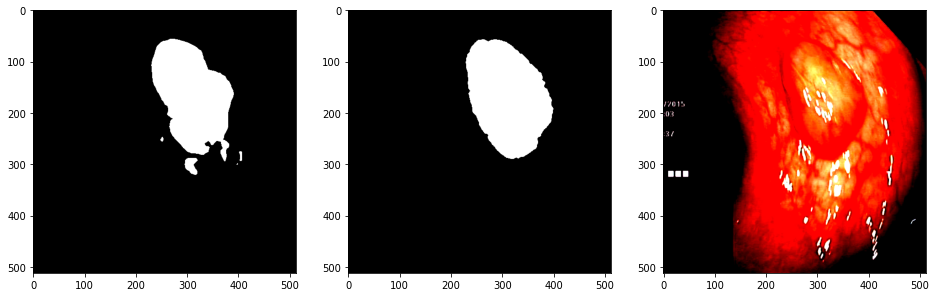

In [19]:
# Randomly inference on one Kvasir image
random_index = random.randint(0, len(kvasir_test_dataset)+1)
img, gt = kvasir_test_dataset[random_index]
img = img[None]
gt = gt
with torch.no_grad():
    _, _, _, pred = model(img.cuda())
    result = pred[0].sigmoid().cpu().numpy()[0]
    result[result >= 0.4] = 1
    result[result < 0.4] = 0
    result.astype(np.uint8)

    plt.figure(figsize=(16, 12))
    plt.subplot(131)
    plt.imshow(result, cmap='gray')
    plt.subplot(132)
    plt.imshow(gt[0], cmap='gray')
    plt.subplot(133)
    plt.imshow(img[0].transpose(0, 2).transpose(0, 1))
    plt.show()

In [20]:
def iou(pred, mask):
    pred, mask = pred.flatten(), mask.flatten()
    tp = sum(pred * mask)
    fp_fn = sum(pred != mask)
    iou = (tp + 1e-6) / (tp + fp_fn + 1e-6)
    return iou

def mae(pred, mask):
    pred, mask = pred.flatten(), mask.flatten()
    abs_error = np.abs(pred - mask)
    mae = np.mean(abs_error)
    return mae

def dice(pred, mask):
    pred, mask = pred.flatten(), mask.flatten()
    intersection = sum(pred * mask)
    dice = ((intersection * 2) + 1e-6) / ((np.sum(mask) + np.sum(pred)) + 1e-6)
    return dice

In [21]:
def compute_metrics(dataset, threshold=0.4):
    # Calculate Metrics
    Miou, Amae, Mdice = [], [], []
    with torch.no_grad():
        for pack in dataset:
            img, gt = pack
            img = img[None]
            _, _, _, pred = model(img.cuda())
            result = pred[0].sigmoid().cpu().numpy()[0]
            result[result > threshold] = 1
            result[result <= threshold] = 0
            result.astype(np.uint8)

            Miou.append(iou(result, gt[0]))
            Amae.append(mae(result, gt[0]))
            Mdice.append(dice(result, gt[0]))

        print('For {}, Mean IOU: {:.4f}, Average MAE: {:.4f}, Mean DICE: {:.4f}'
                             .format(dataset.name, np.mean(Miou), np.mean(Amae), np.mean(Mdice)))

In [22]:
compute_metrics(kvasir_test_dataset)
compute_metrics(cvc_test_dataset)

For KVASIR TEST, Mean IOU: 0.7739, Average MAE: 0.0512, Mean DICE: 0.8485
For CVC TEST, Mean IOU: 0.8369, Average MAE: 0.0187, Mean DICE: 0.8995
